Market Crash Prediction Model

This script implements a market crash prediction model using multiple machine learning techniques:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost

The model uses various features derived from market data:
- VVIX and changes (ΔVVIX, VVIX rolling z-score)
- VIX and VIX rank (percentile over trailing year)
- VIX/VVIX ratio
- Technical indicators (SMA_20, SMA_50, SMA_200)
- Price - SMA_200 (% distance from trend)
- RSI, MACD, ATR
- SPY volatility z-score

A market crash is defined as:
- A 10% or greater decline in SPY within the next 21 trading days (1 month)

In [31]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
import ta  # Technical analysis library
import shap

# Add project root to the path
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
sys.path.append(project_root)

# Import the necessary functions
from src.tools.price_service import get_price_data
from src.strategy.indicator import calculate_indicators, get_indicator_list, create_crash_labels
from src.strategy.ml import split_data, normalize_data, tune_hyperparameters, train_and_evaluate_model, train_and_evaluate_all_models
from src.strategy.pandas_backtest import backtest_option_strategy

# Set up Matplotlib for better display in notebook
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fetch_price_data(tickers, start_date, end_date, force_update=False):
    """
    Retrieve historical price data for the specified tickers.
    
    Args:
        tickers (list): List of ticker symbols to fetch data for
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        force_update (bool): Whether to force update from source instead of using cached data
        
    Returns:
        dict: Dictionary with ticker symbols as keys and dataframes as values
    """
    # Retrieve data from database
    result = {}
    for ticker in tickers:
        df = get_price_data(ticker, start_date, end_date)
        
        df.sort_index(inplace=True)
        # Add daily returns
        df['daily_return'] = df['close'].pct_change()
        
        result[ticker] = df
        
        print(f"Retrieved {len(df)} records for {ticker}")
        print(f"  Date range: {df.index.min().date()} to {df.index.max().date()}")
    
    return result

tickers = ["SPY", "VIX", "VVIX"]
    
# Calculate date range for 10 years
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=365 * 10)).strftime("%Y-%m-%d")

print(f"\nFetching data for {tickers} from {start_date} to {end_date}...")
# Fetch the data
price_data = fetch_price_data(tickers, start_date, end_date)


Fetching data for ['SPY', 'VIX', 'VVIX'] from 2015-05-23 to 2025-05-20...
Retrieved 2508 records for SPY
  Date range: 2015-05-26 to 2025-05-13
Retrieved 2510 records for VIX
  Date range: 2015-05-26 to 2025-05-13
Retrieved 2499 records for VVIX
  Date range: 2015-05-26 to 2025-05-12


In [3]:
# Create the features
print("Creating features...")
if all(ticker in price_data for ticker in ['SPY', 'VIX', 'VVIX']):
    features_df = calculate_indicators(
        price_data['SPY'], 
        price_data['VIX'], 
        price_data['VVIX']
    )
    print(f"Created features dataframe with {len(features_df)} rows and {features_df.shape[1]} columns")
    
    # Display a sample of the features
    features_df.tail().style.background_gradient()
    all_features = get_indicator_list()
else:
    print("Cannot create features: missing required data")

Creating features...
Created features dataframe with 2228 rows and 44 columns


In [4]:
all_features

['return_1d',
 'return_5d',
 'drawdown',
 'volume',
 'volume_3m_ratio',
 'vix',
 'vix_change',
 'vix_rank',
 'vvix',
 'vvix_change',
 'vvix_zscore',
 'vix_vvix_ratio',
 'sma_20',
 'sma_50',
 'sma_200',
 'sma_20_50_cross',
 'sma_20_200_cross',
 'sma_50_200_cross',
 'sma_20_50_crossover',
 'sma_20_200_crossover',
 'sma_50_200_crossover',
 'sma_20_50_distance',
 'sma_20_200_distance',
 'sma_50_200_distance',
 'dist_from_200sma',
 'rsi',
 'macd',
 'macd_signal',
 'macd_diff',
 'atr',
 'spy_vol',
 'spy_vol_zscore']

Created crash labels: 209.0 crash events out of 2498 days
Crash frequency: 8.37%
Common indices: 2219 out of 2498 crash labels


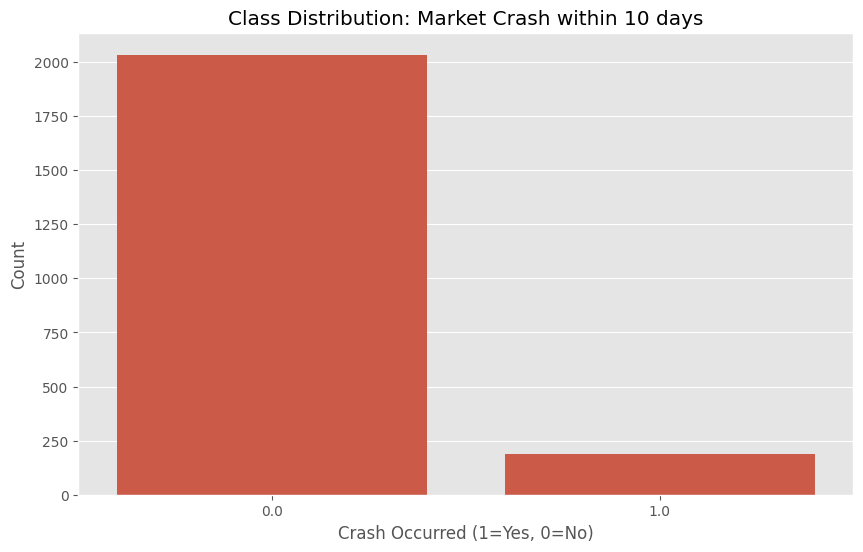

Crash events in final dataset: 186.0 out of 2219 days
Crash frequency in final dataset: 8.38%


In [5]:
# Create the crash labels
forward_days = 10
crash_threshold = -0.05 

if 'SPY' in price_data:
    crash_labels = create_crash_labels(price_data['SPY'], threshold=crash_threshold, forward_days=forward_days)
    print(f"Created crash labels: {crash_labels.sum()} crash events out of {len(crash_labels)} days")
    print(f"Crash frequency: {crash_labels.mean():.2%}")
    
    common_indices = features_df.index.intersection(crash_labels.index)
    print(f"Common indices: {len(common_indices)} out of {len(crash_labels)} crash labels")

    if len(common_indices) > 0:
        # Filter both dataframes to include only the common indices
        crash_labels = crash_labels[common_indices]
        full_dataset = features_df.loc[common_indices].copy()
        full_dataset['crash'] = crash_labels
        
        # Display class balance
        plt.figure(figsize=(10, 6))
        sns.countplot(x='crash', data=full_dataset)
        plt.title(f'Class Distribution: Market Crash within {forward_days} days')
        plt.xlabel('Crash Occurred (1=Yes, 0=No)')
        plt.ylabel('Count')
        plt.show()
        
        print(f"Crash events in final dataset: {crash_labels.sum()} out of {len(crash_labels)} days")
        print(f"Crash frequency in final dataset: {crash_labels.mean():.2%}")
    else:
        print("ERROR: No common indices between features and crash labels")
        # Create an empty dataframe to prevent further errors
        full_dataset = pd.DataFrame()
else:
    print("Cannot create crash labels: missing SPY data")

In [6]:
# Combine features and labels
common_indices = features_df.index.intersection(crash_labels.index)
print(f"Common indices: {len(common_indices)} out of {len(crash_labels)} crash labels")

if len(common_indices) == 0:
    print("ERROR: No common indices between features and crash labels")

# Filter both dataframes to include only the common indices
crash_labels = crash_labels[common_indices]
full_dataset = features_df.loc[common_indices].copy()
full_dataset['crash'] = crash_labels

# Display class balance
print(f"Crash events in final dataset: {crash_labels.sum()} out of {len(crash_labels)} days")
print(f"Crash frequency in final dataset: {crash_labels.mean():.2%}")

Common indices: 2219 out of 2219 crash labels
Crash events in final dataset: 186.0 out of 2219 days
Crash frequency in final dataset: 8.38%


In [7]:
# Use all features for this analysis (could be modified to use best_features)
selected_features = ['return_1d',
 'return_5d',
 'drawdown',
 'volume_3m_ratio',
 'vix_change',
 'vix_rank',
 'vvix',
 'vvix_change',
 'vvix_zscore',
 'vix_vvix_ratio',
 #'sma_20',
 #'sma_50',
 #'sma_200',
 'sma_20_50_distance',
 'sma_20_200_distance',
 'sma_50_200_distance',
 'dist_from_200sma',
 'rsi',
 'macd',
 'macd_signal',
 'macd_diff',
 'atr',
 'spy_vol',
 'spy_vol_zscore']

In [8]:
# Select features and target
X = full_dataset[selected_features]
y = full_dataset['crash']

In [9]:
# Data splitting
print("\nSplitting data into train, validation, and test sets...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_ratio=0.7, val_ratio=0.15)


Splitting data into train, validation, and test sets...
Training set: 1553 samples from 2016-06-21 to 2022-08-31
Validation set: 332 samples from 2022-09-01 to 2023-12-27
Test set: 334 samples from 2023-12-28 to 2025-04-29

Crash events in training set: 143.0 (9.21%)
Crash events in validation set: 18.0 (5.42%)
Crash events in test set: 25.0 (7.49%)


Training set: 1331 samples from 2016-06-21 to 2021-10-13
Validation set: 443 samples from 2021-10-14 to 2023-07-20
Test set: 445 samples from 2023-07-21 to 2025-04-29

Crash events in training set: 91.0 (6.84%)
Crash events in validation set: 67.0 (15.12%)
Crash events in test set: 28.0 (6.29%)

Normalizing data...
Using RobustScaler (median and IQR) - recommended for financial data with outliers
Training set shape: (1331, 21)
Validation set shape: (443, 21)
Test set shape: (445, 21)

Tuning hyperparameters for xgb model...
Fitting 2 folds for each of 1024 candidates, totalling 2048 fits

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 10.227848101265822, 'subsample': 0.8}
Best cross-validation score: 0.6425

XGB Model - Overfitting Analysis:
  Training set - Accuracy: 0.9632, ROC AUC: 0.9966
  Validation set - Accuracy: 0.7810, ROC AUC: 0.733

C:\Users\lswht\AppData\Local\pypoetry\Cache\virtualenvs\ai-hedge-fund-vthGiggG-py3.12\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:58:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\lswht\AppData\Local\pypoetry\Cache\virtualenvs\ai-hedge-fund-vthGiggG-py3.12\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:58:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


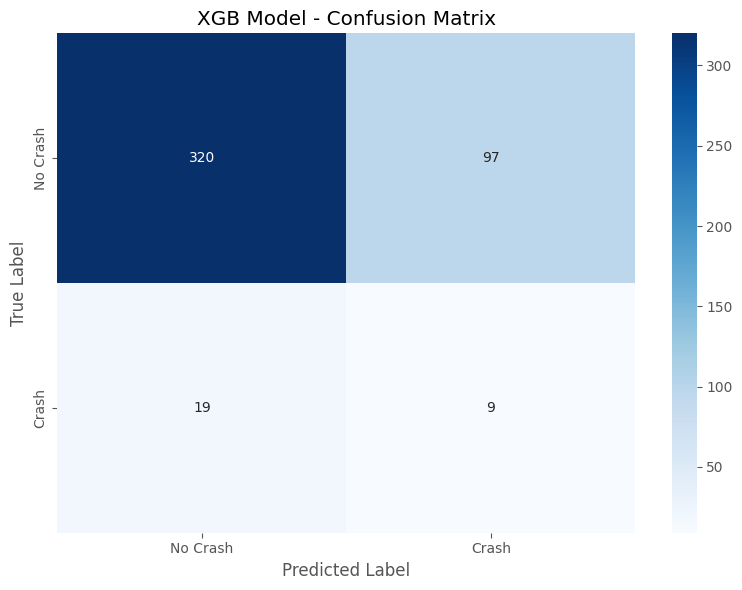

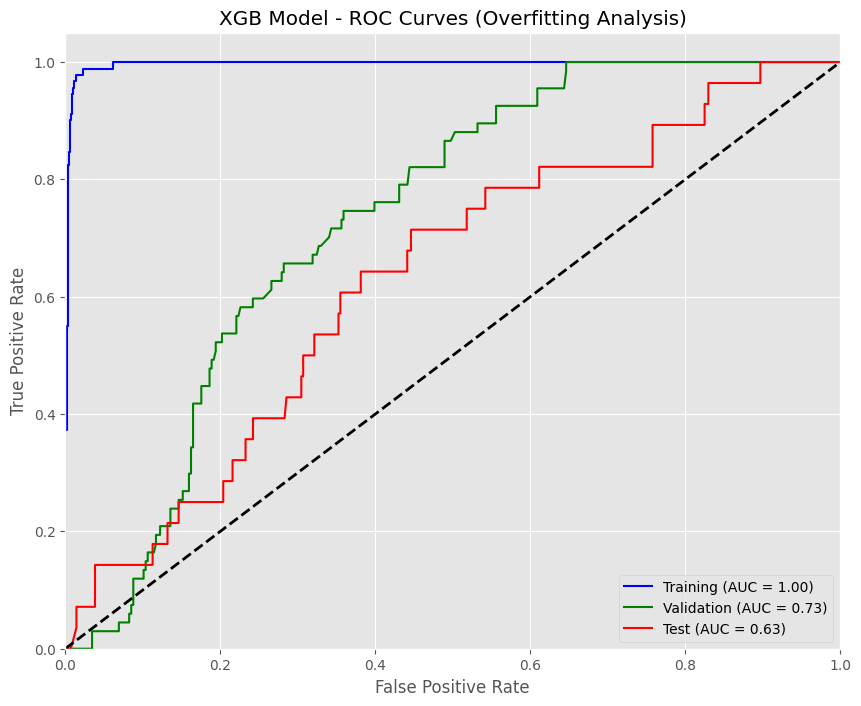

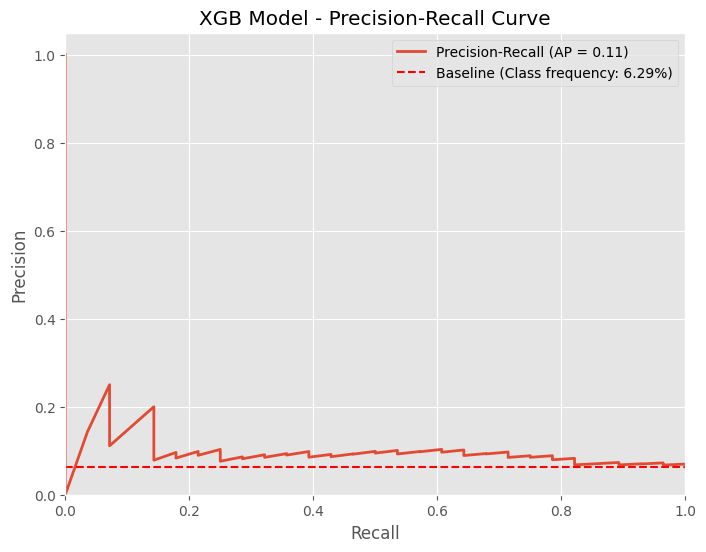

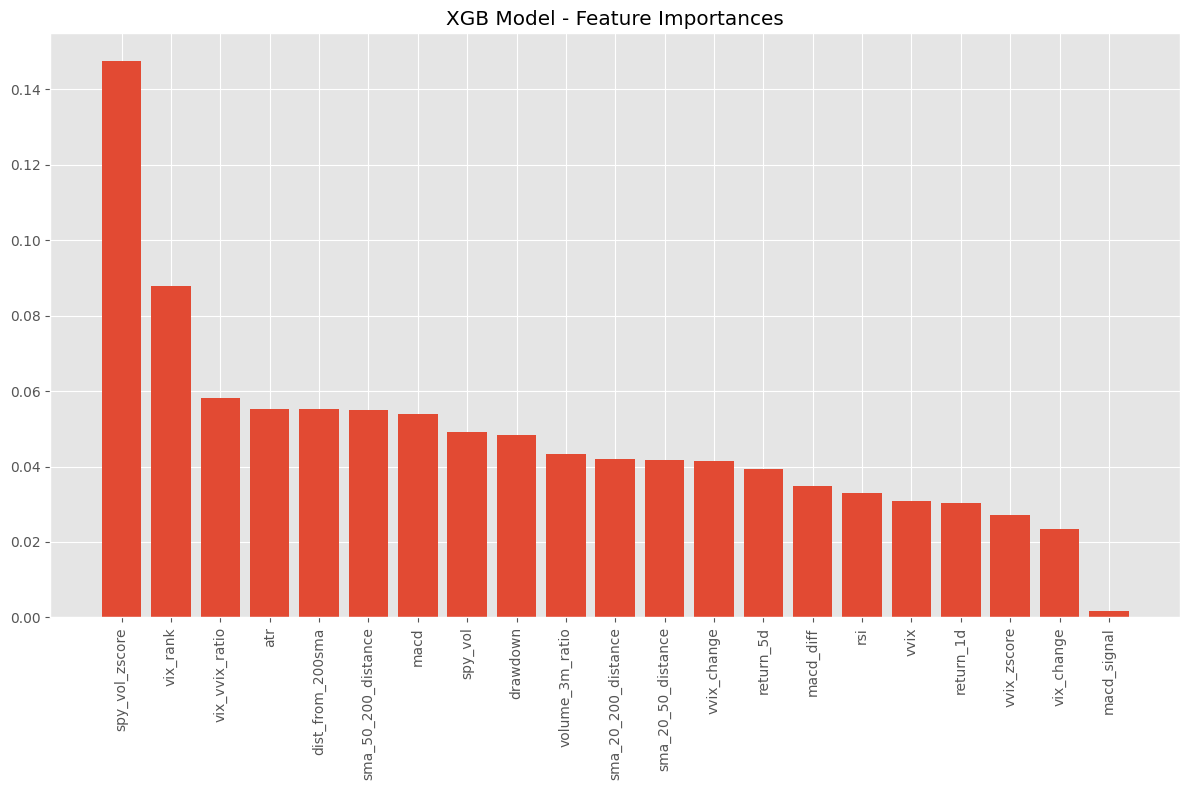


Analyzing SHAP values for xgb model...


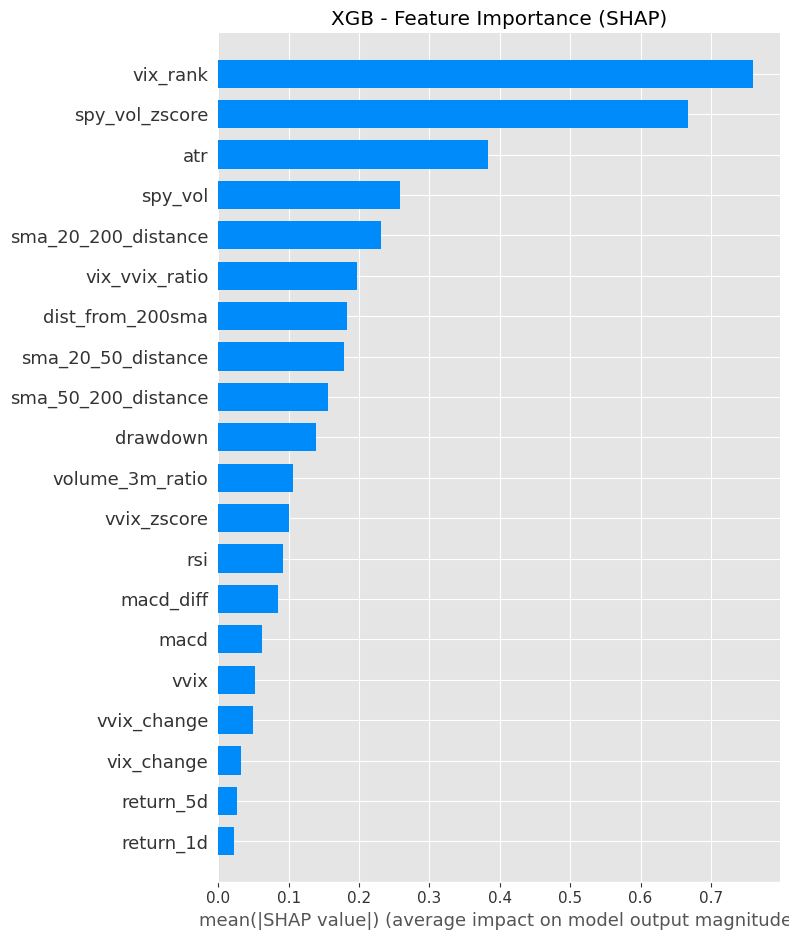

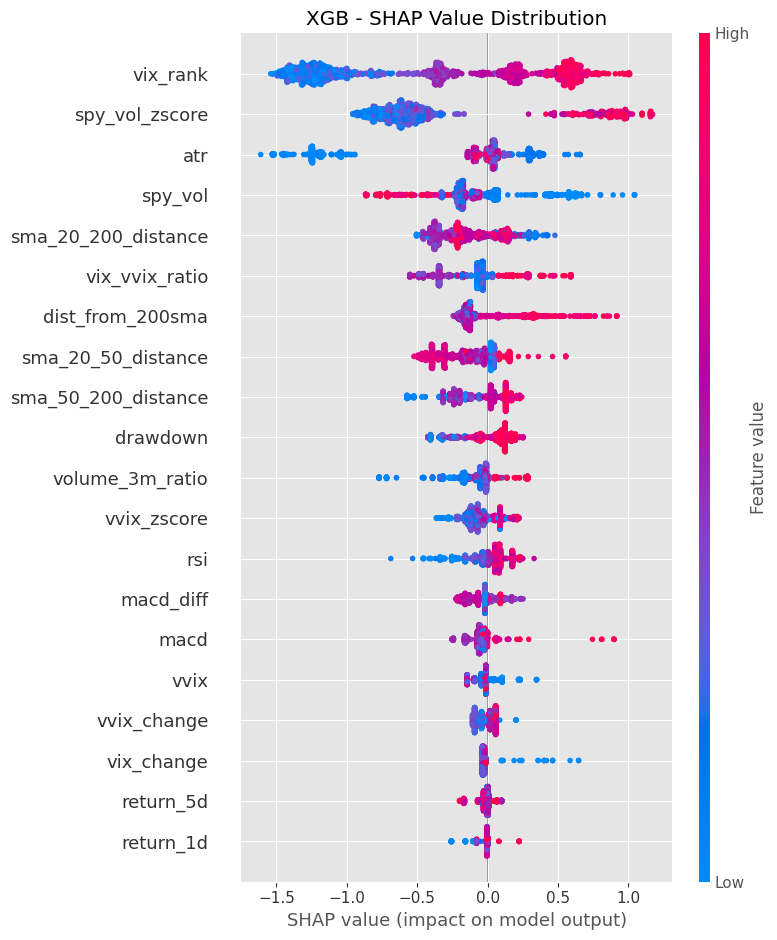


Top 10 Most Important Features:
            Feature  Importance
           vix_rank    0.760101
     spy_vol_zscore    0.667911
                atr    0.382698
            spy_vol    0.258023
sma_20_200_distance    0.231674
     vix_vvix_ratio    0.196907
   dist_from_200sma    0.182488
 sma_20_50_distance    0.178914
sma_50_200_distance    0.156006
           drawdown    0.138328
Context:
We are analyzing a market crash prediction system that uses machine learning to predict potential market crashes. The system is implemented in our codebase with the following components:
- Market indicators and features are calculated in indicator.py
- The ML model training and prediction logic is in ml.py
- The backtesting strategy is implemented in pandas_backtest.py

The model predicts the probability of a market crash occurring in the next N days, where a crash is defined as a significant market decline (e.g., >10% drop in SPY).

Please explain the XGB model's prediction for 2023-07-21 00:00:00:

OSError: [Errno 22] Invalid argument: 'model_explanation_2023-07-21 00:00:00.txt'

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from src.strategy.ml import train_and_evaluate_model, tune_hyperparameters
from src.strategy.ml import split_data, normalize_data, generate_model_explanation_prompt

# Assuming you have your data loaded and model trained
# If not, first train your model:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
X_train_scaled, X_val_scaled, X_test_scaled, scaler = normalize_data(X_train, X_val, X_test)

# Train model (example with XGBoost)
model_type = 'xgb'
model, val_score, params = tune_hyperparameters(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    model_type=model_type,
    n_splits=2
)

# Train and get predictions
trained_model, test_probs, report = train_and_evaluate_model(
    model, X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    model_name=f"{model_type.upper()} Model"
)

# Create SHAP explainer
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_test_scaled)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification



In [33]:
# Choose a date to analyze (example: first test set date)
idx = 200
date = X_test.index[idx]  # Get the date from your test set index
features = X_test.iloc[idx]  # Features for that date
prediction_prob = test_probs[idx]   # Model's prediction
shap_values_for_date = shap_values[idx]  # SHAP values for that date

# Generate the explanation prompt
prompt = generate_model_explanation_prompt(
    date=date,
    features=features,
    prediction_prob=prediction_prob,
    shap_values=shap_values_for_date,
    feature_names=X_test_scaled.columns,
    model_type=model_type,
    top_n_features=5  # You can change this to show more or fewer features
)

# Print the prompt
print(prompt)



Context:
We are analyzing a market crash prediction system that uses machine learning to predict potential market crashes. 

The model predicts the probability of a market crash occurring in the next 10 days, where a crash is defined as a significant market decline (e.g., >10% drop in SPY).

Please explain the XGB model's prediction for 2024-05-07 00:00:00:

Prediction Details:
- Date: 2024-05-07 00:00:00
- Predicted Probability: 0.324
- Model Type: XGB

Top 5 Influential Features:
- vix_rank: Value = 0.198, SHAP Impact = -1.368
- spy_vol_zscore: Value = 1.534, SHAP Impact = 0.871
- vix_vvix_ratio: Value = 0.177, SHAP Impact = -0.388
- sma_20_200_distance: Value = 8.372, SHAP Impact = 0.288
- vvix: Value = 74.540, SHAP Impact = 0.221

Please explain:
1. Why did the model predict this probability? Consider the market conditions and feature values.
2. How did each of these top features influence the prediction? Explain the relationship between each feature's value and its SHAP impact.
3.

In [10]:
# Data normalization
print("\nNormalizing data...")
X_train_scaled, X_val_scaled, X_test_scaled, scaler = normalize_data(X_train, X_val, X_test, scaler_type='robust')


Normalizing data...

Normalizing data...
Using RobustScaler (median and IQR) - recommended for financial data with outliers
Training set shape: (1553, 21)
Validation set shape: (332, 21)
Test set shape: (334, 21)


In [21]:
min(logistic_probs)

0.2593212690696449

In [34]:
# Train all models
results = train_and_evaluate_all_models(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    fast_mode=False
)

# Access results for each model
logistic_model, logistic_probs, logistic_report, logistic_params = results['logistic']
rf_model, rf_probs, rf_report, rf_params = results['rf']
gb_model, gb_probs, gb_report, gb_params = results['gb']
xgb_model, xgb_probs, xgb_report, xgb_params = results['xgb']

NameError: name 'class_weight' is not defined

Model predictions saved to logs/model_predictions.csv


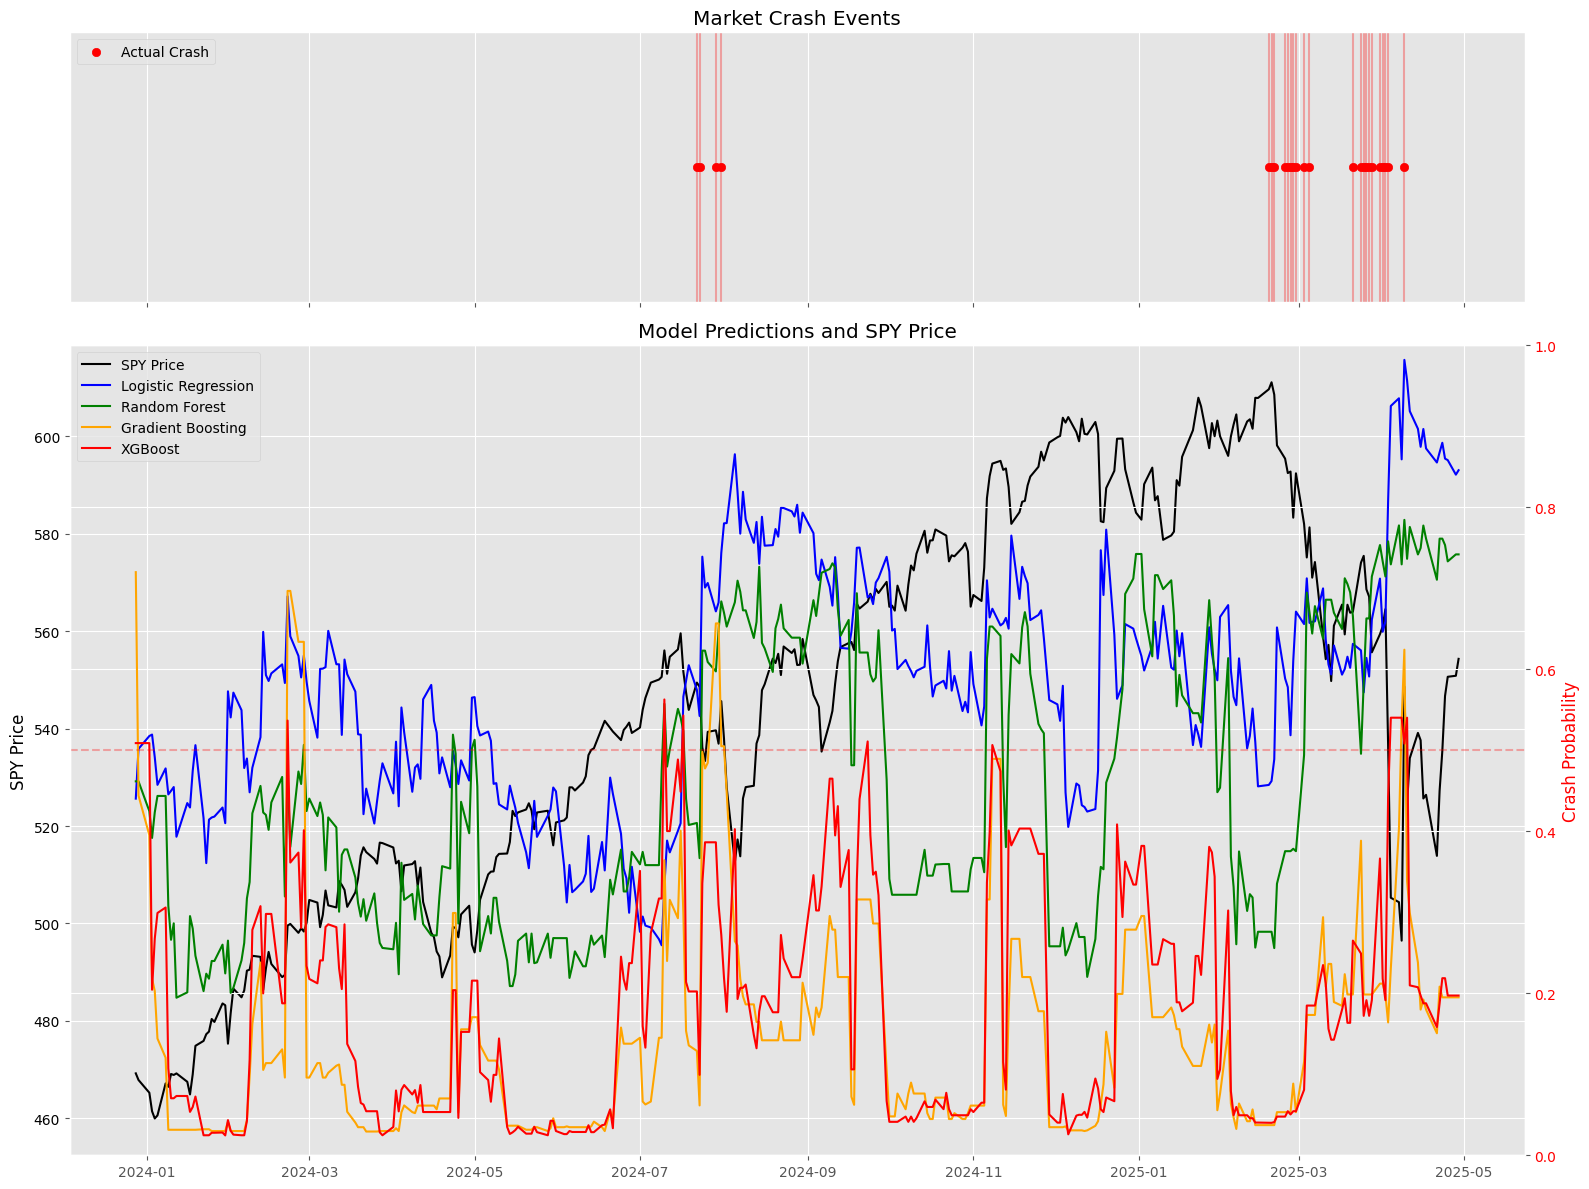

In [22]:
# Create a DataFrame with test results for visualization
results_df = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Logistic_Prob': logistic_probs,
    'RF_Prob': rf_probs,
    'GB_Prob': gb_probs,
    'XGB_Prob': xgb_probs,
    'SPY_Price': full_dataset.loc[X_test.index, 'close']
})
#results_df.to_csv("logs/model_predictions.csv")
print("Model predictions saved to logs/model_predictions.csv")

# Plot the probabilities over time with SPY price
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# Plot crash events on top plot
crash_dates = results_df[results_df['Actual'] == 1].Date
for date in crash_dates:
    ax1.axvline(x=date, color='red', alpha=0.3)
ax1.scatter(crash_dates, [1] * len(crash_dates), color='red', label='Actual Crash')
ax1.set_yticks([])
ax1.set_title('Market Crash Events')
ax1.legend()

# Plot SPY price and model probabilities on bottom plot
ax2.plot(results_df['Date'], results_df['SPY_Price'], color='black', label='SPY Price')
ax2.set_ylabel('SPY Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for probabilities
ax3 = ax2.twinx()
ax3.plot(results_df['Date'], results_df['Logistic_Prob'], color='blue', label='Logistic Regression')
ax3.plot(results_df['Date'], results_df['RF_Prob'], color='green', label='Random Forest')
ax3.plot(results_df['Date'], results_df['GB_Prob'], color='orange', label='Gradient Boosting')
ax3.plot(results_df['Date'], results_df['XGB_Prob'], color='red', label='XGBoost')
ax3.set_ylabel('Crash Probability', color='red')
ax3.set_ylim(0, 1)
ax3.tick_params(axis='y', labelcolor='red')

# Add horizontal line at 0.5 probability threshold
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Model Predictions and SPY Price')
plt.tight_layout()
plt.show()
plt.close()


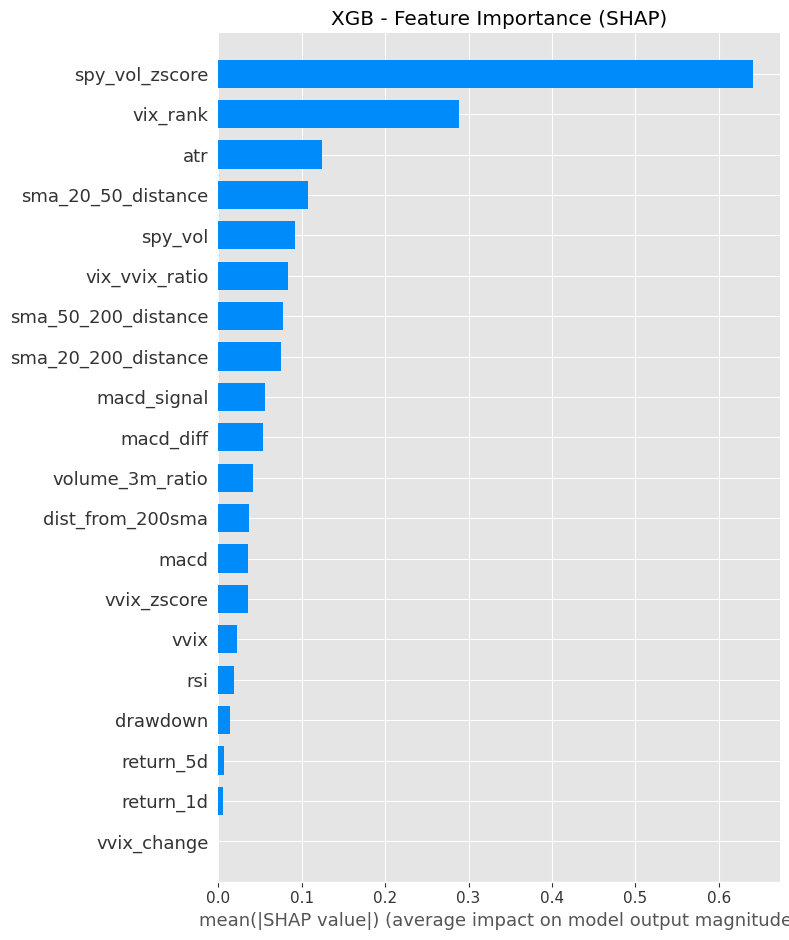

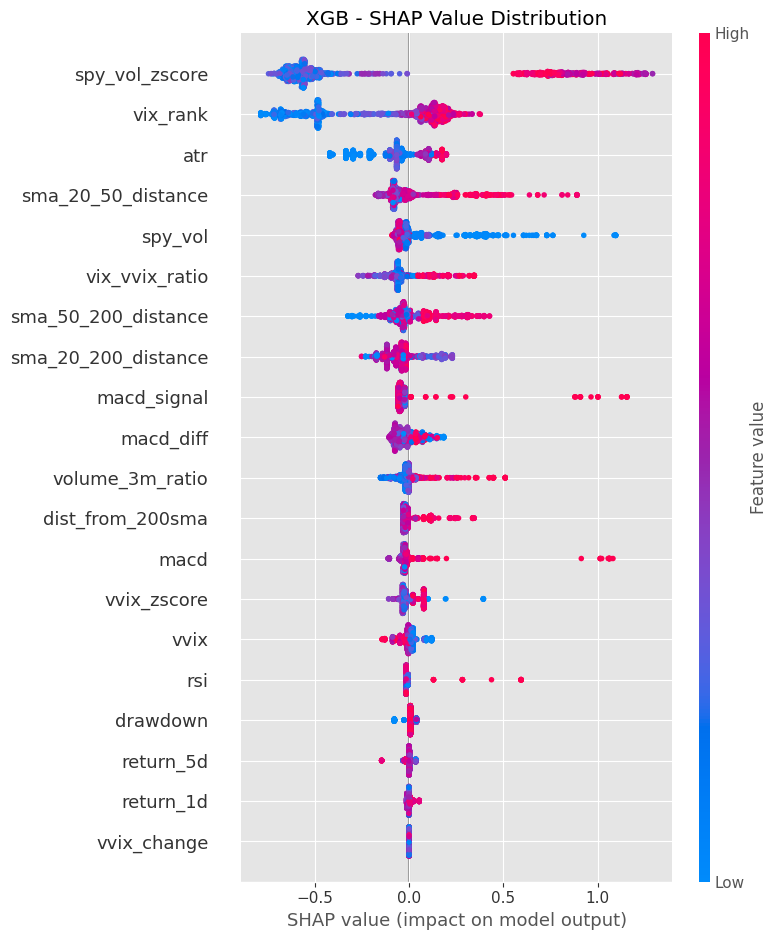


Top 10 Most Important Features:
            Feature  Importance
     spy_vol_zscore    0.641311
           vix_rank    0.288316
                atr    0.123805
 sma_20_50_distance    0.107049
            spy_vol    0.092163
     vix_vvix_ratio    0.083050
sma_50_200_distance    0.077237
sma_20_200_distance    0.075702
        macd_signal    0.056228
          macd_diff    0.053305


<Figure size 1000x400 with 0 Axes>

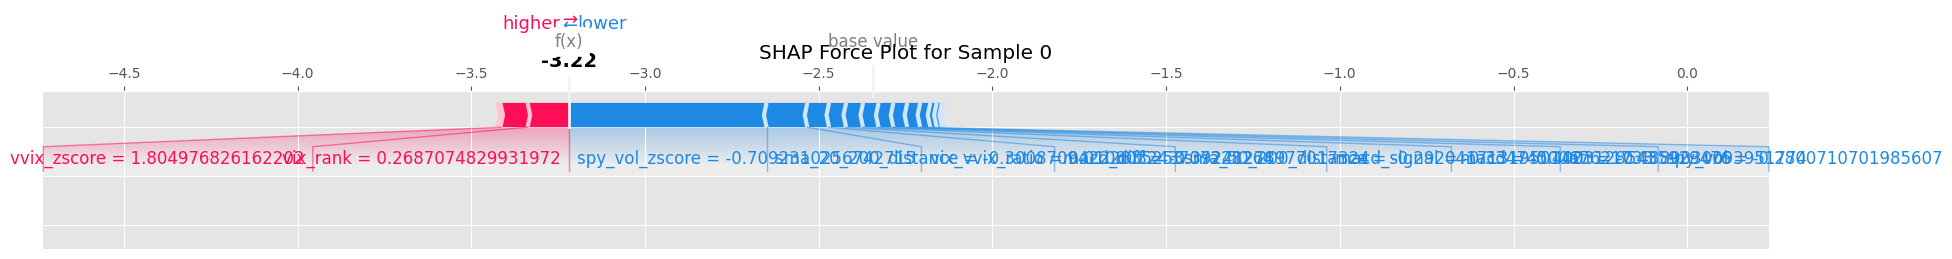

<Figure size 1000x400 with 0 Axes>

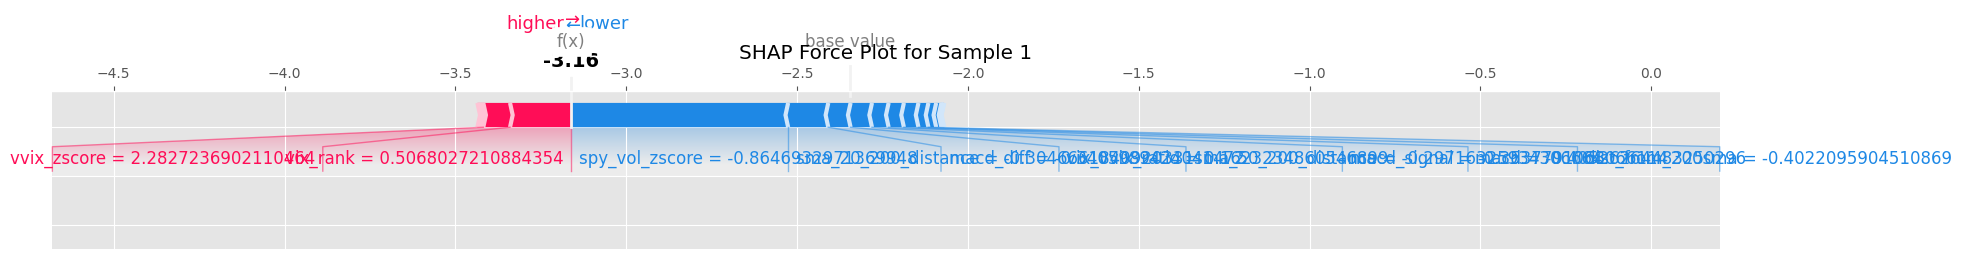

<Figure size 1000x400 with 0 Axes>

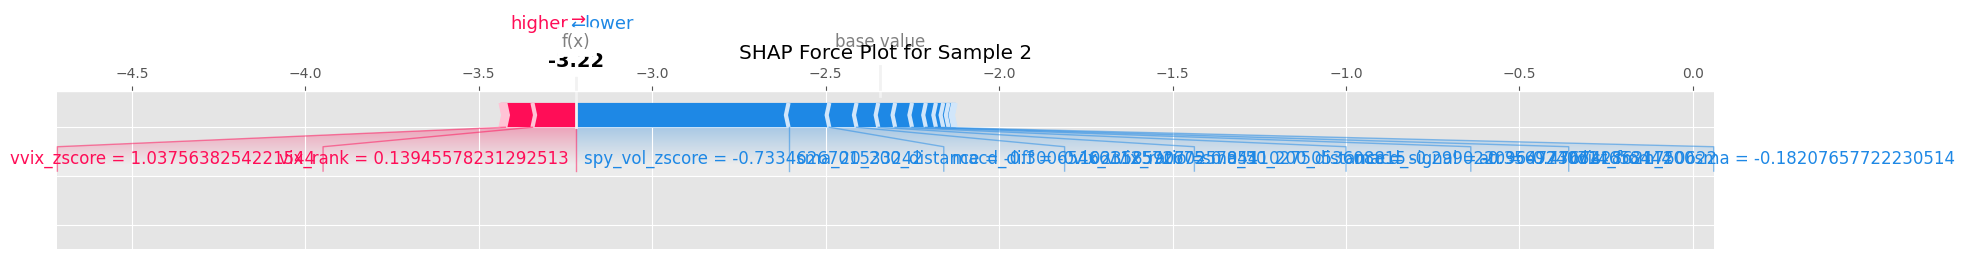

<Figure size 1000x600 with 0 Axes>

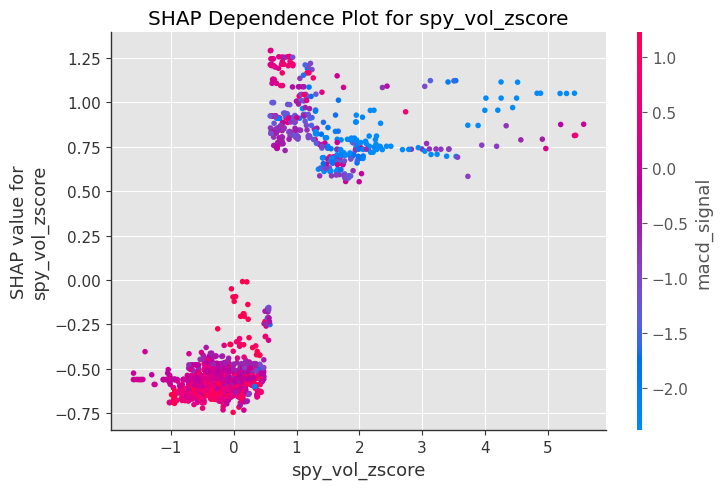

<Figure size 1000x600 with 0 Axes>

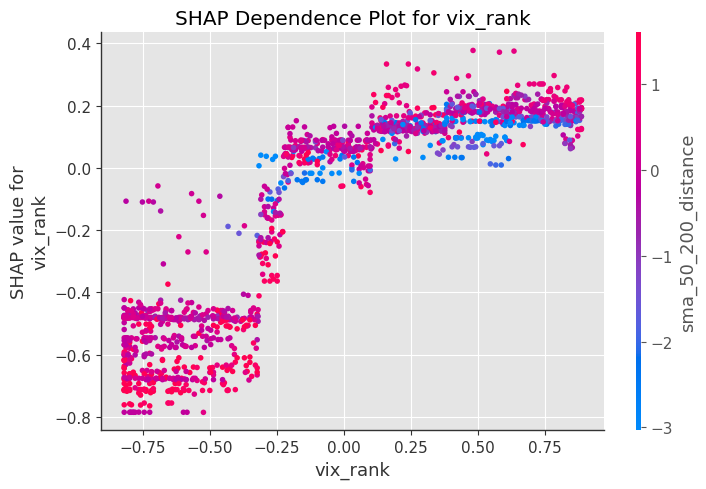

<Figure size 1000x600 with 0 Axes>

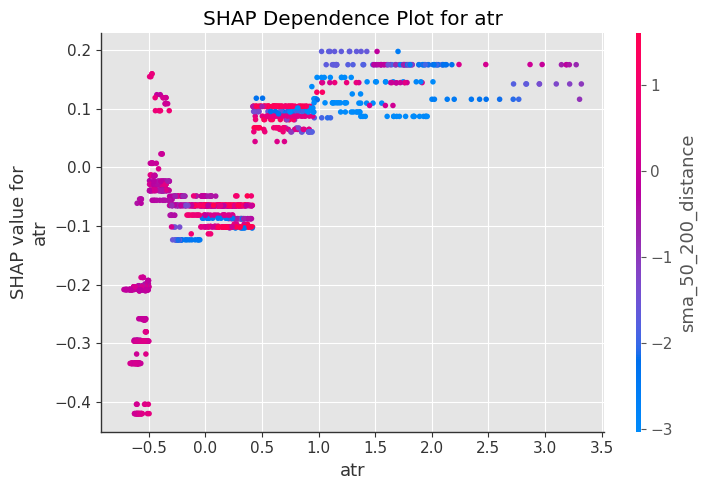

In [26]:
# Assuming you have:
# - trained_model: your trained model
# - X_train_scaled: your scaled training features
# - model_type: type of model ('logistic', 'rf', 'gb', 'xgb')
trained_model = xgb_model
model_type = 'xgb'

# Create SHAP explainer based on model type
if model_type == 'logistic':
    explainer = shap.LinearExplainer(trained_model, X_train_scaled)
else:
    explainer = shap.TreeExplainer(trained_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_scaled)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification, use positive class

# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_train_scaled,
    plot_type="bar",
    show=False
)
plt.title(f"{model_type.upper()} - Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# Plot detailed SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_train_scaled,
    show=False
)
plt.title(f"{model_type.upper()} - SHAP Value Distribution")
plt.tight_layout()
plt.show()

# Print feature importance
mean_shap_values = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': mean_shap_values
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Optional: Analyze specific predictions
# Choose a few interesting samples to analyze
sample_indices = [0, 1, 2]  # Change these to indices you're interested in
for idx in sample_indices:
    plt.figure(figsize=(10, 4))
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_train_scaled.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot for Sample {idx}")
    plt.tight_layout()
    plt.show()

# Optional: Dependence plots for top features
top_features = feature_importance['Feature'].head(3).tolist()
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_train_scaled,
        show=False
    )
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

In [13]:
def backtest_hedging_strategy(model_probs, actual_crashes, spy_prices, threshold=0.5, 
                              hedge_cost_pct=0.00, max_hedge_reduction=0.5):
    """
    Backtest a simple hedging strategy:
    - Reduce market exposure when crash probability exceeds threshold
    - Return to full exposure when probability falls below threshold
    
    Args:
        model_probs: Series of model probabilities
        actual_crashes: Series of actual crash labels
        spy_prices: Series of SPY prices
        threshold: Probability threshold for hedging (default: 0.5)
        hedge_cost_pct: Cost of hedging as % of portfolio per period (default: 0.01%)
        max_hedge_reduction: Maximum reduction in exposure when hedged (default: 50%)
        
    Returns:
        DataFrame: Strategy results
    """
    # Initialize strategy DataFrame
    strategy = pd.DataFrame({
        'date': model_probs.index,
        'spy_price': spy_prices,
        'spy_return': spy_prices.pct_change(),
        'prob': model_probs,
        'actual_crash': actual_crashes,
        'signal': (model_probs >= threshold).astype(int)
    })
    
    # Fill NaN in first row
    strategy.iloc[0, strategy.columns.get_loc('spy_return')] = 0
    
    # Calculate strategy returns
    strategy['hedged'] = strategy['signal'].shift(1).fillna(0)  # Apply signal from previous day
    strategy['exposure'] = 1.0 - (strategy['hedged'] * max_hedge_reduction)
    strategy['hedge_cost'] = strategy['hedged'] * hedge_cost_pct
    strategy['strategy_return'] = (strategy['spy_return'] * strategy['exposure']) - strategy['hedge_cost']
    
    # Calculate cumulative returns
    strategy['cum_spy_return'] = (1 + strategy['spy_return']).cumprod() - 1
    strategy['cum_strategy_return'] = (1 + strategy['strategy_return']).cumprod() - 1
    
    # Calculate drawdowns
    strategy['spy_peak'] = strategy['cum_spy_return'].cummax()
    strategy['strategy_peak'] = strategy['cum_strategy_return'].cummax()
    
    strategy['spy_drawdown'] = (strategy['cum_spy_return'] - strategy['spy_peak'])
    strategy['strategy_drawdown'] = (strategy['cum_strategy_return'] - strategy['strategy_peak'])
    
    # Calculate performance metrics
    total_periods = len(strategy)
    hedged_periods = strategy['hedged'].sum()
    hedged_pct = hedged_periods / total_periods
    
    spy_return = strategy['cum_spy_return'].iloc[-1]
    strategy_return = strategy['cum_strategy_return'].iloc[-1]
    
    spy_max_drawdown = strategy['spy_drawdown'].min()
    strategy_max_drawdown = strategy['strategy_drawdown'].min()
    
    spy_volatility = strategy['spy_return'].std() * np.sqrt(252)  # Annualized
    strategy_volatility = strategy['strategy_return'].std() * np.sqrt(252)  # Annualized
    
    spy_sharpe = spy_return / spy_volatility if spy_volatility > 0 else 0
    strategy_sharpe = strategy_return / strategy_volatility if strategy_volatility > 0 else 0
    
    # Display metrics
    print(f"Strategy Performance (threshold = {threshold}):")
    print(f"Hedged periods: {hedged_periods} ({hedged_pct:.2%} of the time)")
    print(f"SPY Return: {spy_return:.2%}, Strategy Return: {strategy_return:.2%}")
    print(f"SPY Max Drawdown: {spy_max_drawdown:.2%}, Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
    print(f"SPY Volatility: {spy_volatility:.2%}, Strategy Volatility: {strategy_volatility:.2%}")
    print(f"SPY Sharpe: {spy_sharpe:.2f}, Strategy Sharpe: {strategy_sharpe:.2f}")
    
    # Plot cumulative returns
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Cumulative Returns
    plt.subplot(2, 1, 1)
    plt.plot(strategy['date'], strategy['cum_spy_return'], 'b-', label='SPY')
    plt.plot(strategy['date'], strategy['cum_strategy_return'], 'g-', label='Hedging Strategy')
    
    # Highlight periods when hedged
    hedged_periods = strategy[strategy['hedged'] == 1]
    for i in range(len(hedged_periods)):
        plt.axvspan(hedged_periods.iloc[i].date, 
                   hedged_periods.iloc[i].date, 
                   color='lightgray', alpha=0.3)
    
    # Mark crash events
    crash_dates = strategy[strategy['actual_crash'] == 1].date
    for date in crash_dates:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)
    
    plt.title('Cumulative Returns: SPY vs Hedging Strategy')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Drawdowns
    plt.subplot(2, 1, 2)
    plt.plot(strategy['date'], strategy['spy_drawdown'], 'b-', label='SPY Drawdown')
    plt.plot(strategy['date'], strategy['strategy_drawdown'], 'g-', label='Strategy Drawdown')
    plt.fill_between(strategy['date'], strategy['spy_drawdown'], 0, color='blue', alpha=0.1)
    plt.fill_between(strategy['date'], strategy['strategy_drawdown'], 0, color='green', alpha=0.1)
    
    plt.title('Drawdowns: SPY vs Hedging Strategy')
    plt.ylabel('Drawdown')
    plt.ylim(min(spy_max_drawdown, strategy_max_drawdown) * 1.1, 0.05)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return strategy


Backtesting RF-based hedging strategy...
Strategy Performance (threshold = 0.4):
Hedged periods: 171.0 (51.20% of the time)
SPY Return: 18.13%, Strategy Return: 14.08%
SPY Max Drawdown: -24.42%, Strategy Max Drawdown: -14.59%
SPY Volatility: 18.28%, Strategy Volatility: 11.71%
SPY Sharpe: 0.99, Strategy Sharpe: 1.20


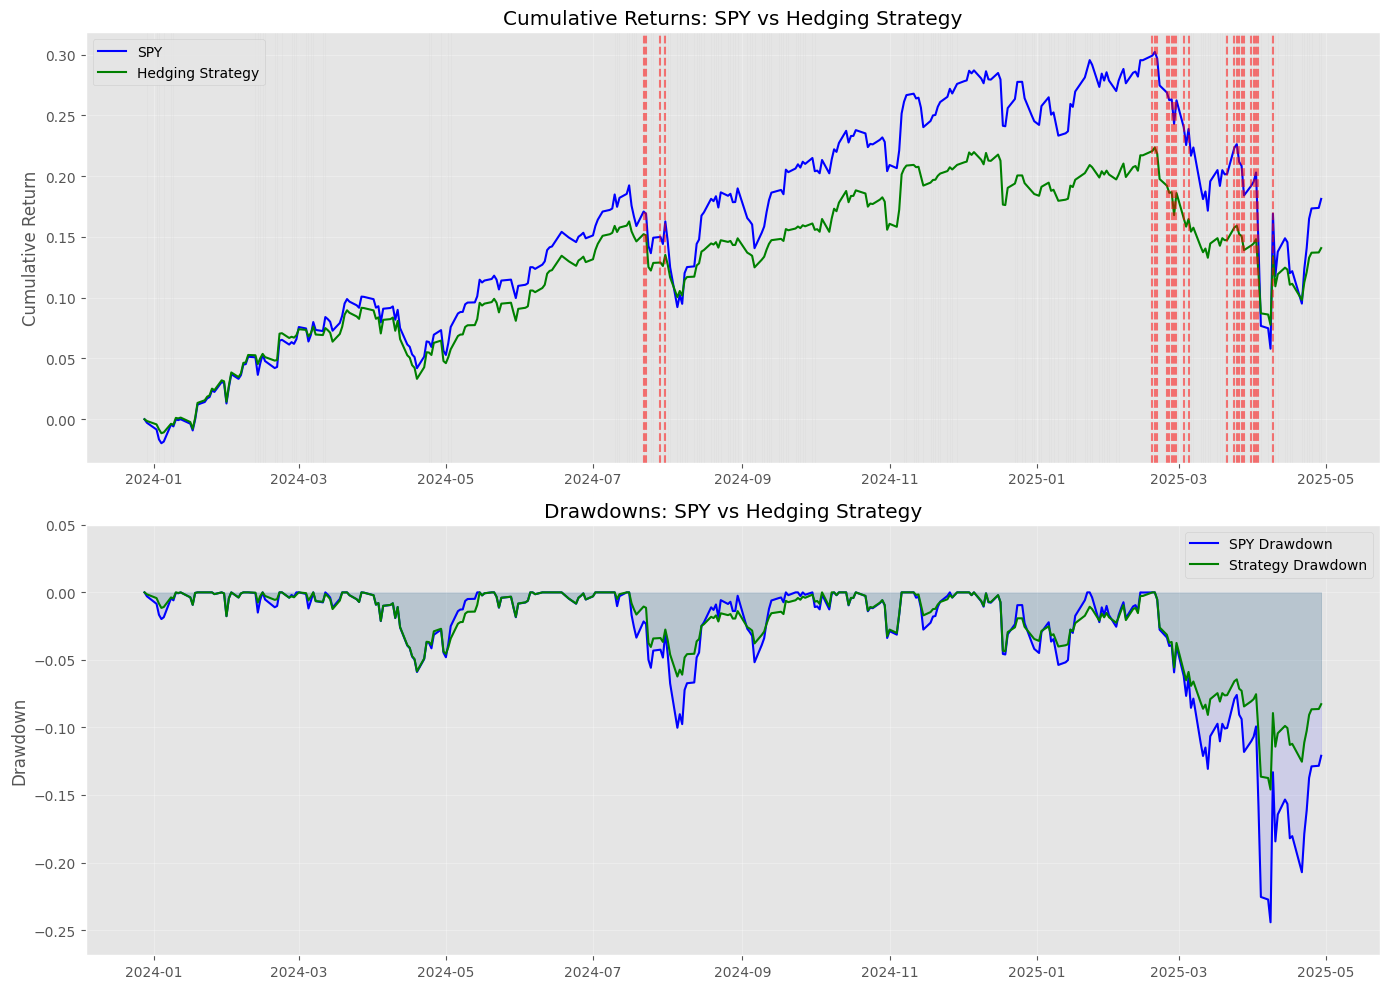

Strategy Performance (threshold = 0.5):
Hedged periods: 130.0 (38.92% of the time)
SPY Return: 18.13%, Strategy Return: 16.62%
SPY Max Drawdown: -24.42%, Strategy Max Drawdown: -15.52%
SPY Volatility: 18.28%, Strategy Volatility: 12.26%
SPY Sharpe: 0.99, Strategy Sharpe: 1.36


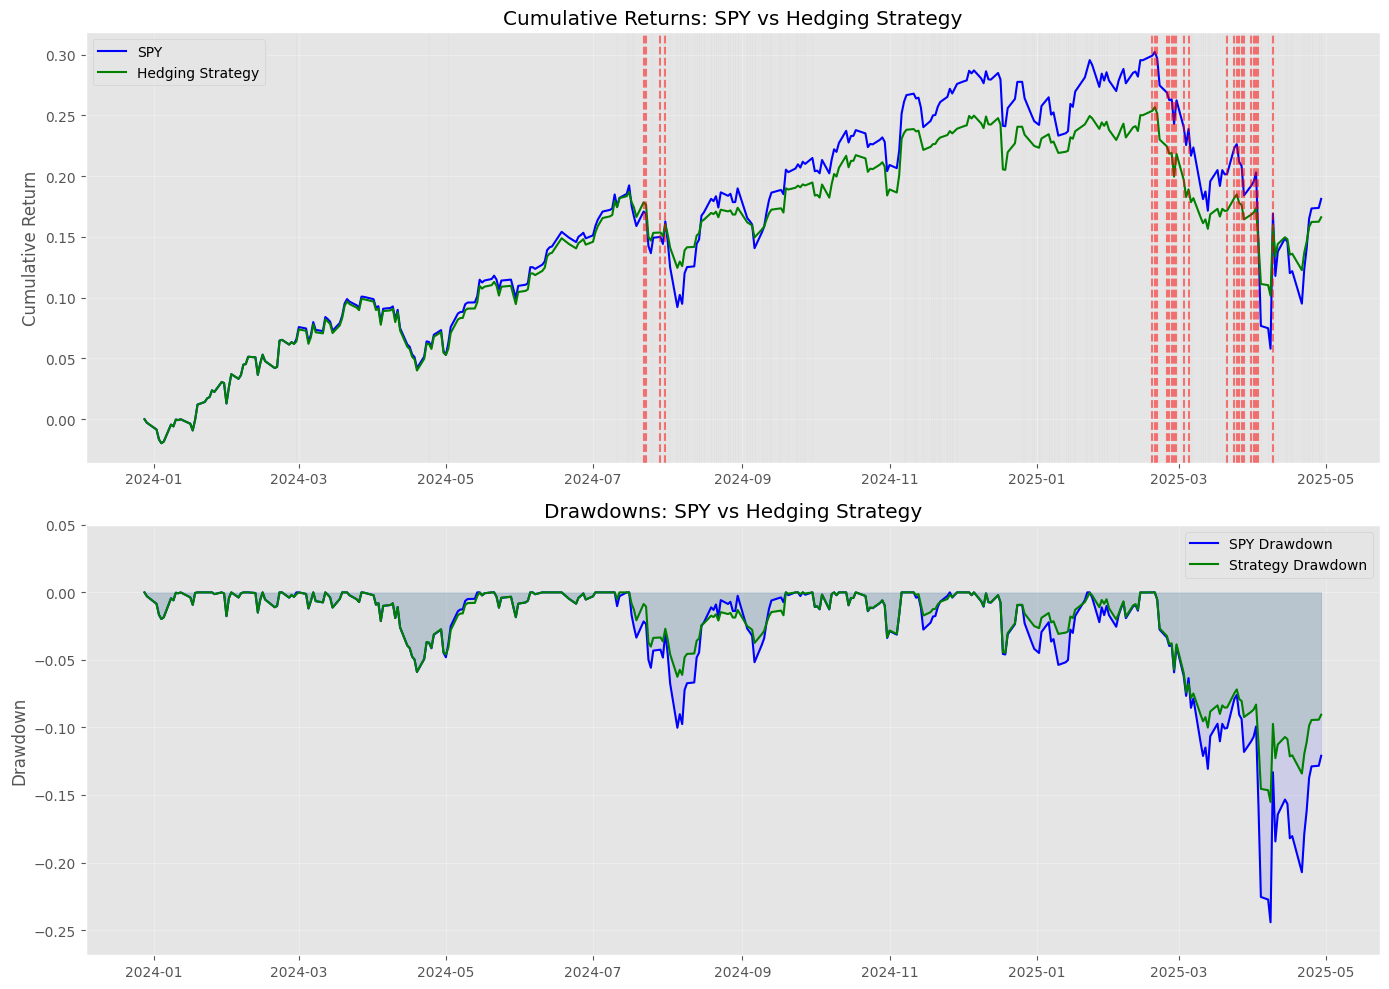

Strategy Performance (threshold = 0.6):
Hedged periods: 100.0 (29.94% of the time)
SPY Return: 18.13%, Strategy Return: 15.07%
SPY Max Drawdown: -24.42%, Strategy Max Drawdown: -16.08%
SPY Volatility: 18.28%, Strategy Volatility: 12.62%
SPY Sharpe: 0.99, Strategy Sharpe: 1.19


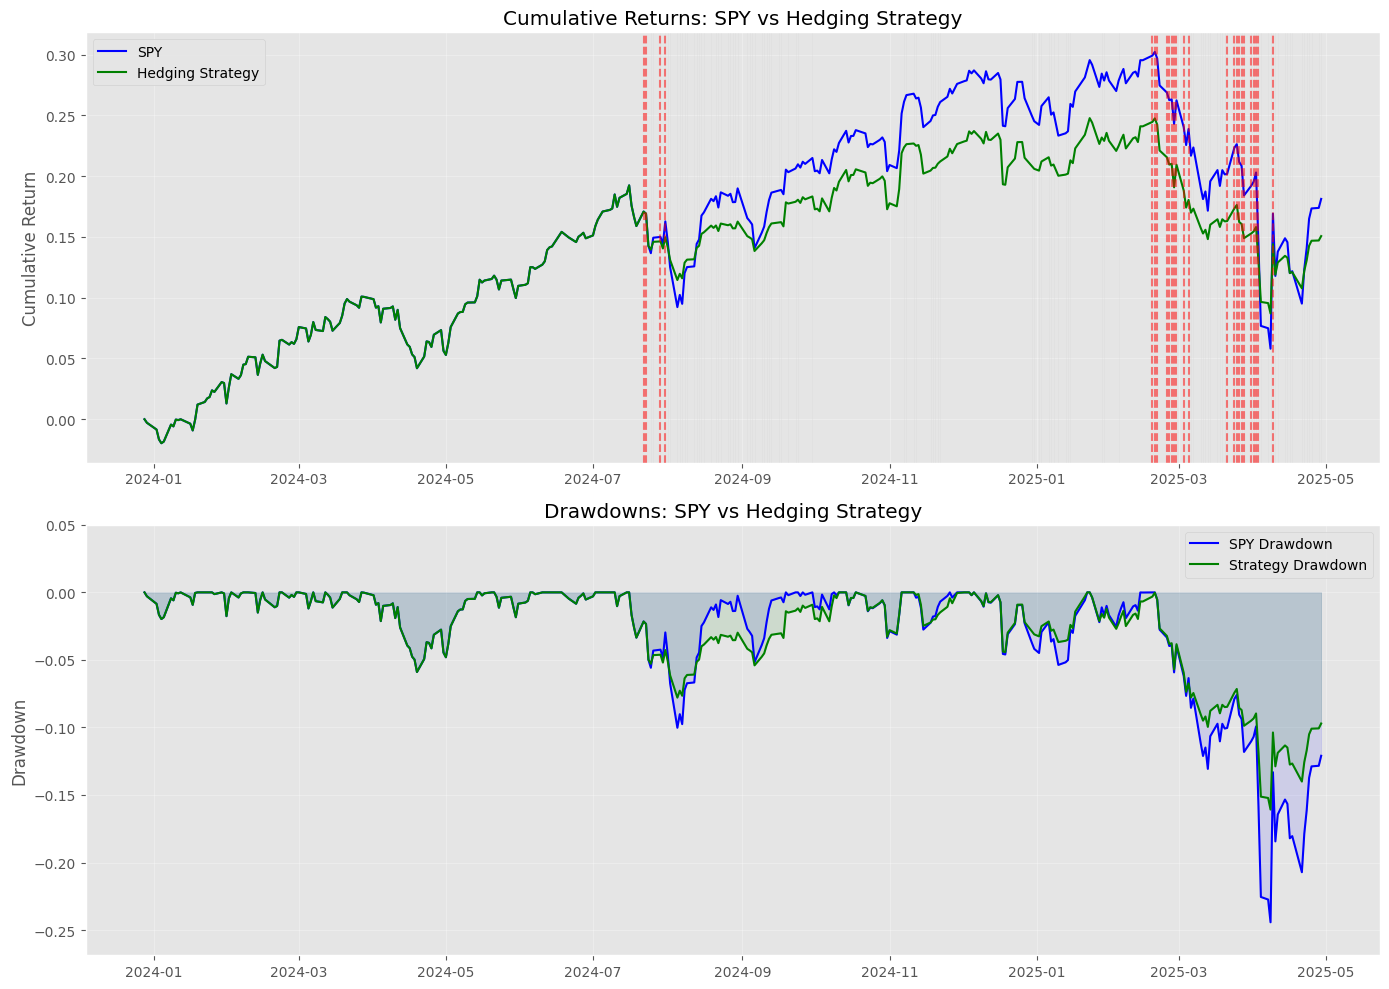

In [14]:
print("\nBacktesting RF-based hedging strategy...")
strategy_results = {}
for threshold in [0.4, 0.5, 0.6]:
    strategy_results[threshold] = backtest_hedging_strategy(
        pd.Series(rf_probs, index=X_test.index),
        y_test,
        full_dataset.loc[X_test.index, 'close'],
        threshold=threshold,
        hedge_cost_pct=0.0,  # 2 basis points per day (roughly cost of put options)
        max_hedge_reduction=0.5  # Reduce exposure by up to 50%
    )


Backtesting RF-based option strategy...

Backtesting option-based strategy (threshold = 0.4)...


F:\workspace\ai-hedge-fund\src\strategy\pandas_backtest.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.3600000000000136' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategy.iloc[i, strategy.columns.get_loc('cum_benchmark_dollar_return')] = strategy.iloc[i]['benchmark_balance'] - initial_balance
F:\workspace\ai-hedge-fund\src\strategy\pandas_backtest.py:205: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0028983036399284237' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategy.iloc[i, strategy.columns.get_loc('cum_benchmark_return')] = strategy.iloc[i]['cum_benchmark_dollar_return'] / initial_balance
F:\workspace\ai-hedge-fund\src\strategy\pandas_backtest.py:207: FutureWarning: Setting an item of incompatible dtype is depr

Option Strategy Performance (threshold = 0.4):
Option positions opened: 3
Exit types - Expiry: 1, Threshold exits: 1, Still active: 0
SPY Return: 18.13%, Strategy Return: 16.65%
SPY Max Drawdown: -24.42%, Strategy Max Drawdown: -19.11%
SPY Max Drawdown Duration: 48 days, Strategy Max Drawdown Duration: 59 days
SPY Volatility: 18.28%, Strategy Volatility: 15.47%
SPY Sharpe: 0.99, Strategy Sharpe: 1.08
Total option cost: 121.93537803849256


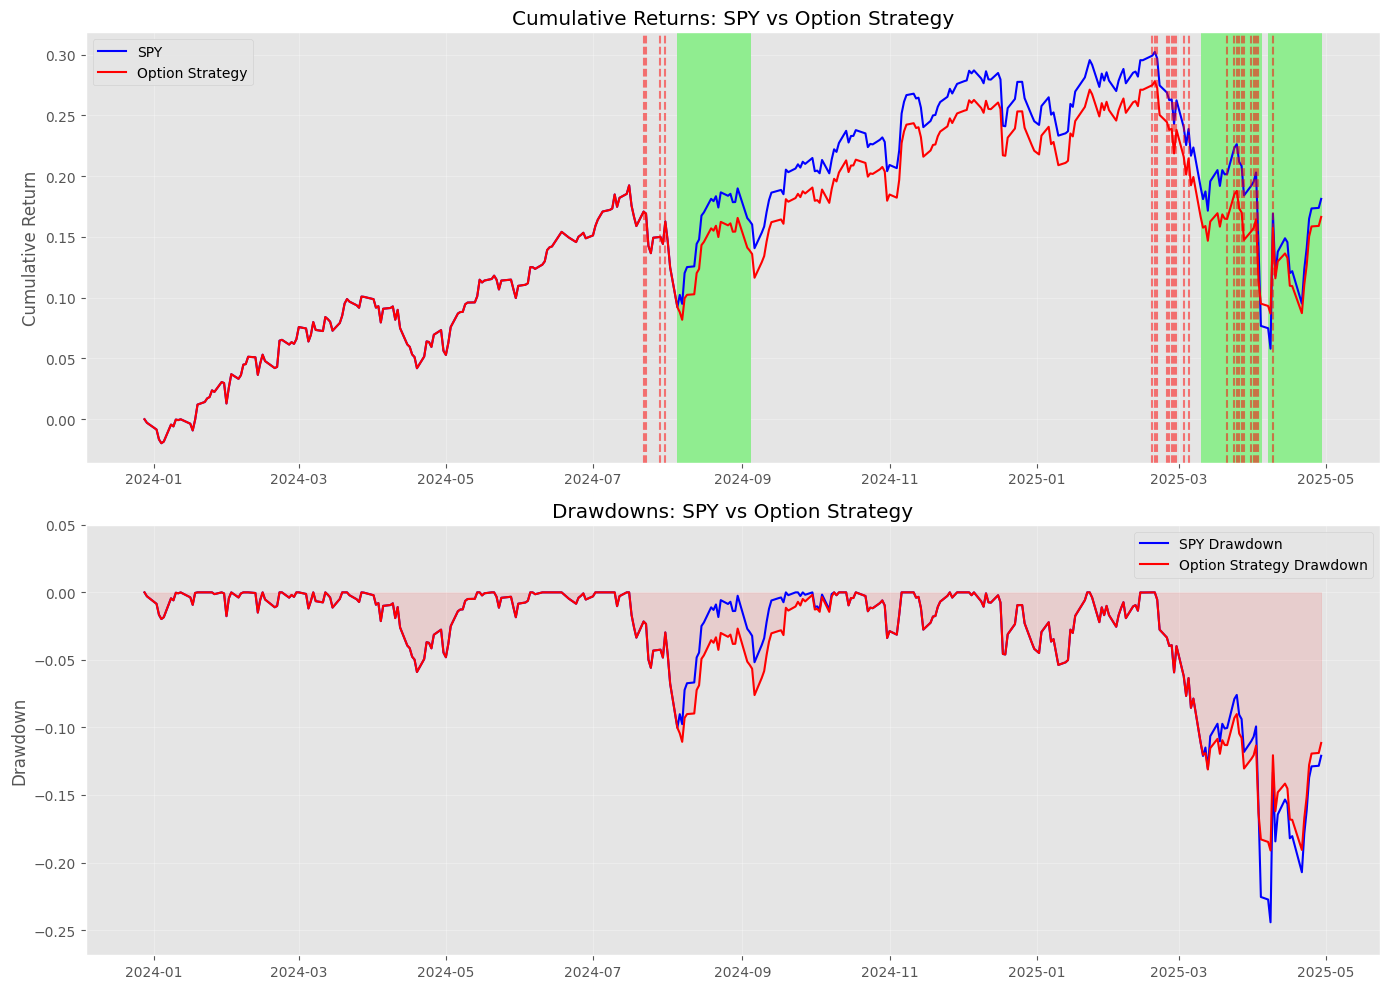

In [17]:
print("\nBacktesting RF-based option strategy...")
option_strategy_results = {}
threshold = 0.4
strike_pct=0.95
option_expiry_days=int(252 / 12)
print(f"\nBacktesting option-based strategy (threshold = {threshold})...")

backtest_X = X_test

backetst_y = y_test

spy_prices = full_dataset.loc[backtest_X.index, 'close']
vix_values = full_dataset.loc[backtest_X.index, 'vix']

scaler = StandardScaler()
backtest_X_scaled = pd.DataFrame(
    scaler.fit_transform(backtest_X),
    columns=backtest_X.columns,
    index=backtest_X.index
)

model_probs = xgb_model.predict_proba(backtest_X_scaled)[:, 1]

option_strategy_results[threshold] = backtest_option_strategy(
    pd.Series(model_probs, index=backtest_X.index),
    backetst_y,
    spy_prices,
    vix_values,
    threshold=threshold,
    strike_pct=strike_pct,
    option_expiry_days=option_expiry_days,
)

In [ ]:
print("\nBacktesting RF-based option strategy...")
option_strategy_results = {}
threshold = 0.6
strike_pct=0.9
option_expiry_days=int(252 / 12)
print(f"\nBacktesting option-based strategy (threshold = {threshold})...")
spy_prices = full_dataset.loc[X_test.index, 'close']
vix_values = full_dataset.loc[X_test.index, 'vix']

option_strategy_results[threshold] = backtest_option_strategy(
    pd.Series(rf_probs, index=X_test.index),
    y_test,
    spy_prices,
    vix_values,
    threshold=threshold,
    strike_pct=strike_pct,
    option_expiry_days=option_expiry_days,
)